In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors
import matplotlib.colors
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from adjustText import adjust_text
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import geopandas as gpd
from utils import *
%config InlineBackend.figure_format = 'retina'

In [2]:
# parameters
focal_year = 2020
#github_activity_NA = "#ebedef"
github_activity_NA = "#a9acb0"

**Figure 1 -- ECI_software overview**

In [3]:
# data -- ECI_software
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[cdf["year"]==focal_year]
ubiquity_order = cdf[["language", "ubiquity"]].drop_duplicates().sort_values(by="ubiquity", ascending=False)["language"].to_list()

# data -- world map
cmap = gpd.read_file("../data/world-administrative-boundaries.geojson")
cmap = cmap[["iso3", "iso_3166_1_alpha_2_codes", "name", "geometry"]].rename(columns={"iso_3166_1_alpha_2_codes" : "iso2"})

In [4]:
def mcp_matrix(df, key_columns, heatmap, custom_colors, labels, fontsize, ax=None):
    table = df[key_columns]
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[0],
        columns=key_columns[1],
        aggfunc="sum",
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        #custom_colors = ["#ffffff", "#08306b"]
        custom_cmap = mcolors.ListedColormap(custom_colors)
        sns.heatmap(table, cbar=False, cmap=custom_cmap, ax=ax)
        ax.set_title(labels[0], size=fontsize)
        ax.set_xlabel(labels[1], size=fontsize-2)
        ax.set_ylabel(labels[2], size=fontsize-2)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        
# mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, custom_colors=["#ffffff", "#08306b"], labels=["Software", "Country", "Language"], fontsize=20)

In [5]:
# mcp trade / technology / research
trade_cdf = pd.read_csv("../outputs/trade_cdf_2020.csv", sep=";")
patent_cdf = pd.read_csv("../outputs/patent_cdf_2020.csv", sep=";")
research_cdf = pd.read_csv("../outputs/research_cdf_2020.csv", sep=";")

#mcp_matrix(trade_cdf, key_columns=["product", "iso2_code", "mcp"], heatmap=False, labels=["Trade", "Country", "Product category"], fontsize=20)
#mcp_matrix(patent_cdf, key_columns=["class", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "Country", "Patent class"], fontsize=20)
#mcp_matrix(research_cdf, key_columns=["category", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=20)

In [49]:
def map_complexity(geodf, c_column, fontsize, ax=None):
    if ax is None:
        ax = plt.gca()

    # create colormap for valid data
    cvals = [geodf[c_column].min(), geodf[c_column].max()]
    colors = ["#08306b", "#ffffff"]
    norm = plt.Normalize(min(cvals), max(cvals))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", list(zip(map(norm, cvals), colors)))

    # define NA color
    cmap.set_bad(color=github_activity_NA)

    # plot the main map
    geodf.plot(column=c_column, cmap=cmap, edgecolor="None", ax=ax, missing_kwds={"color": github_activity_NA})

    # add boundaries
    geodf.boundary.plot(color="lightgrey", linewidth=0.125, ax=ax)

    # create axes divider for colorbar
    divider = make_axes_locatable(ax)

    # main colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = inset_axes(ax, width="50%", height="80%",
                    loc="lower left",
                    # x-axis, y-axis, width, height
                    bbox_to_anchor=(0.955, 0.15, 0.035, 0.85),
                    bbox_transform=ax.transAxes,
                    borderpad=-1)
    cbar = plt.colorbar(sm, cax=cax)

    # define colorbar ticks
    tick_positions = [1, 50, 100, 150]
    cbar.set_ticks(tick_positions)

    # set the tick labels, replacing the last one with "NA"
    tick_labels = [1, 50, 100, 150]
    cbar.ax.yaxis.set_tick_params(pad=2, width=0.5, labelsize=fontsize-4)
    cbar.ax.invert_yaxis()
    cbar.set_label("ECI (software) ranking", rotation=90, labelpad=12, fontsize=fontsize)

    for spine in cbar.ax.spines.values():
        spine.set_linewidth(0.5)

    # add NA patch
    na_patch = mpatches.Rectangle(
        (0, -0.1), 1, 0.05,  
        color=github_activity_NA, 
        transform=cax.transAxes, 
        clip_on=False, 
        edgecolor="black",
        linewidth=1
    )
    cax.add_patch(na_patch)

    # position the NA label to the right of the patch
    cax.text(2, -0.055, "NA", fontsize=fontsize-4, ha="left", va="top", transform=cax.transAxes)
    ax.axis('off')


In [21]:
cmap2 = pd.merge(
    cmap,
    cdf[["iso2_code", "eci"]].drop_duplicates(),
    left_on="iso2",
    right_on="iso2_code",
    how="left"
)
cmap2["eci_software_rank"] = cmap2["eci"].rank(ascending=False)

#map_complexity(cmap2, c_column="eci_software_rank", fontsize=20)

In [22]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

df2 = pd.merge(
    df2,
    cmap[["iso2", "iso3"]].drop_duplicates(),
    left_on="iso2_code",
    right_on="iso2",
    how="left"
)

df2 = normalize_column_to_range(df2, "software_eci_2020")
df2 = normalize_column_to_range(df2, "trade_eci_2020")
df2 = normalize_column_to_range(df2, "tech_eci_2020")
df2 = normalize_column_to_range(df2, "research_eci_2020")

In [23]:
def eci_correlation_plot(df, selected_countries, key_variables, xlabel, ylabel, fontsize, ax=None):
    if ax is None:
        ax = plt.gca()

    # highlighting the selected countries
    color_dict = {1: "#08306b", 0: "#B4C0D2"}
    df["group_color"] = df["iso2_code"].isin(selected_countries).astype(int)

    # scatter plots
    sns.scatterplot(
        x=key_variables[0],
        y=key_variables[1],
        data=df[df["group_color"] == 0],
        hue=df["group_color"][df["group_color"] == 0],
        palette=color_dict,
        legend=False,
        ax=ax,
        zorder=5
    )
    sns.scatterplot(
        x=key_variables[0],
        y=key_variables[1],
        data=df[df["group_color"] == 1],
        hue=df["group_color"][df["group_color"] == 1],
        palette=color_dict,
        legend=False,
        ax=ax,
        zorder=6
    )    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color="lightgrey",zorder=2)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[key_variables[0]], df[key_variables[1]])
    r_squared = r_value ** 2
    print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   ", key_variables[0], "  ", key_variables[1])
    ax.set_xlabel(xlabel, size=fontsize)
    ax.set_ylabel(ylabel, size=fontsize)
    ax.tick_params("x", labelsize=(fontsize-4))
    ax.tick_params("y", labelsize=(fontsize-4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0.015, tight=True)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticklabels(["-1", "", "0", "", "1"])  
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])  
    ax.set_yticklabels(["-1", "", "0", "", "1"])  
    
    # add labels to selected countries
    for index, row in df.iterrows():
        if row["iso2_code"] in selected_countries:
            ax.text(row[key_variables[0]] + 0.05, row[key_variables[1]] + 0.05, row["iso3"], fontsize=fontsize-4, zorder=6)
   

#eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel=True, ylabel="ECI (trade)")

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_22636/802141624.py:48: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  na_patch = mpatches.Rectangle(


R2 0.597 p-value 0.0     trade_eci_2020    software_eci_2020
R2 0.606 p-value 0.0     tech_eci_2020    software_eci_2020
R2 0.523 p-value 0.0     research_eci_2020    software_eci_2020


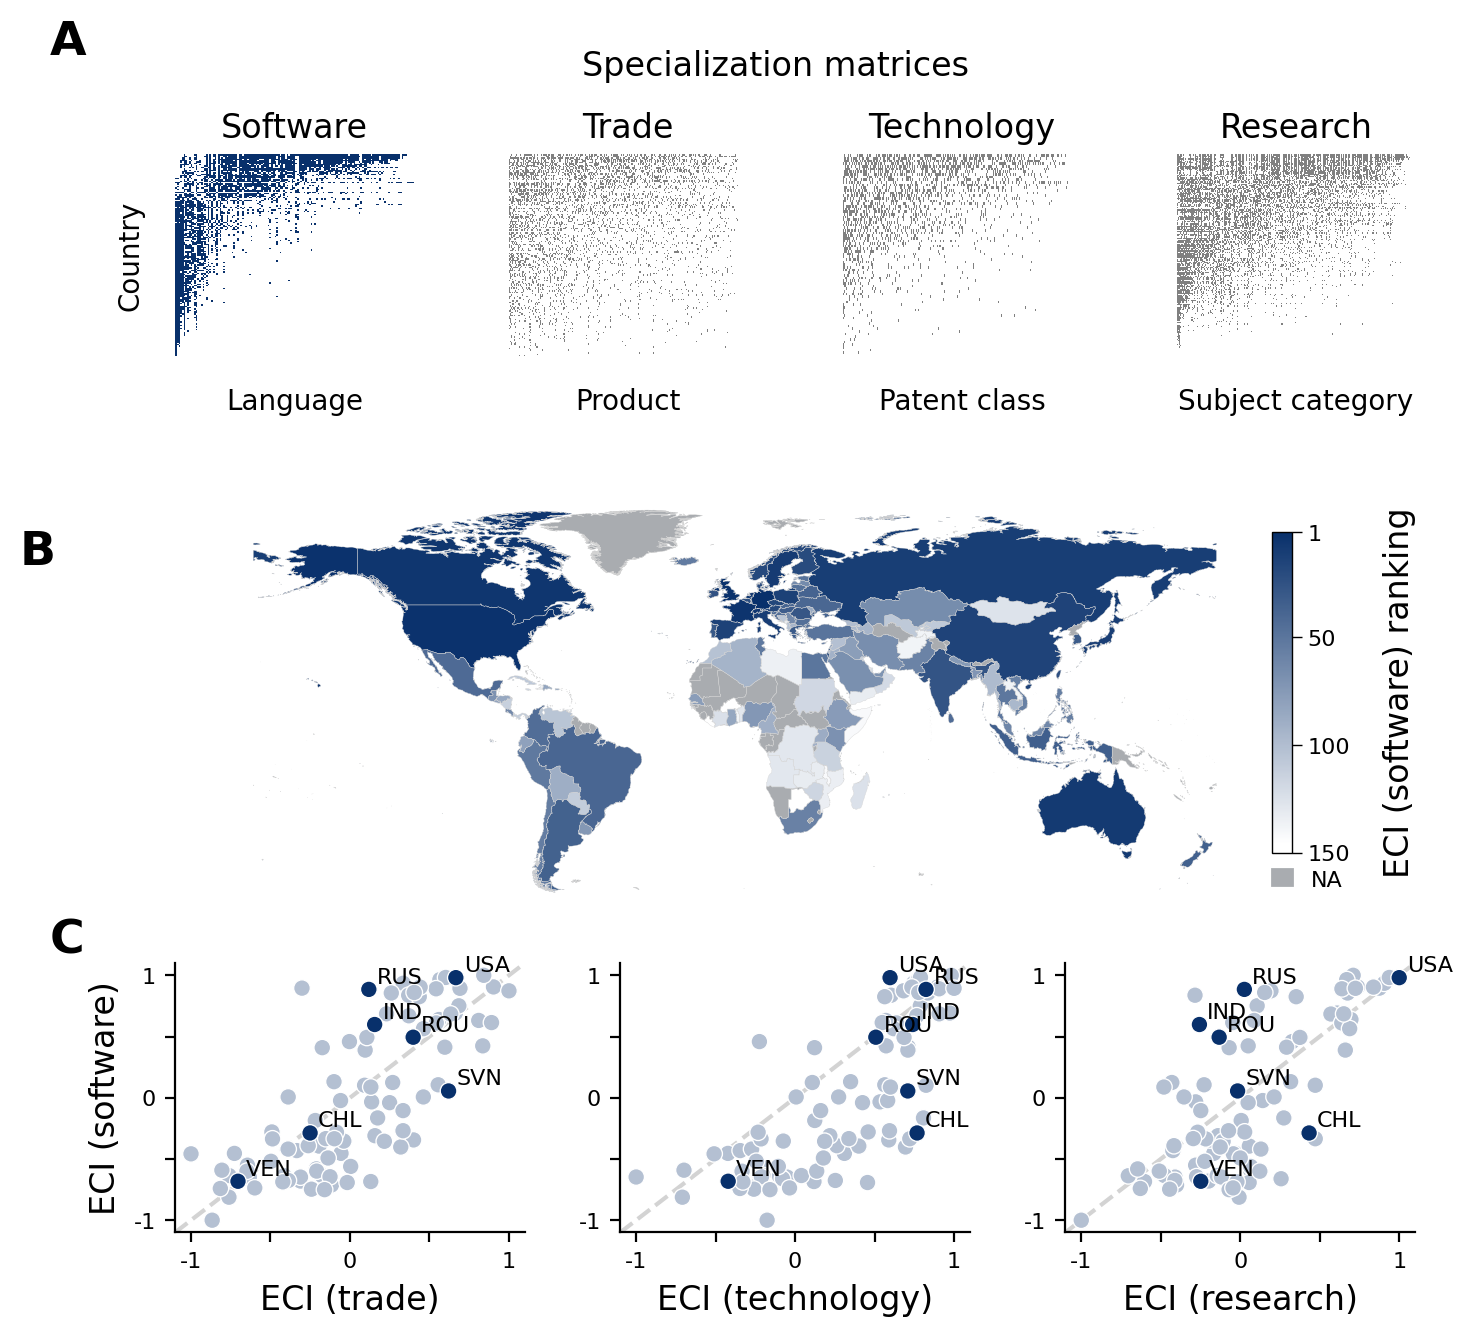

In [78]:
#selected_countries = ["US", "RU", "CL"]
#selected_countries = ["US", "RU", "CL", "AU", "IN", "CN"]
selected_countries = ["US", "RU", "CL", "IN", "VE", "SI", "RO"]
fontsize = 12
fig = plt.figure(figsize=(8,7))

ax = [0]*8
gs = GridSpec(3,12, figure=fig, height_ratios=[1.5, 3.5, 2], hspace=0.215, wspace=6) #, height_ratios=[0.7, 0.7, 0.7, 2, 0.7, 0.7, 0.7], width_ratios=[1, 1, 1, 1, 1, 1], hspace=1.1, wspace=0.85)

ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[0,3:6])
ax[2] = fig.add_subplot(gs[0,6:9])
ax[3] = fig.add_subplot(gs[0,9:12])
ax[4] = fig.add_subplot(gs[1,0:12])
ax[5] = fig.add_subplot(gs[2,0:4])
ax[6] = fig.add_subplot(gs[2,4:8])
ax[7] = fig.add_subplot(gs[2,8:12])


# joint title for the first row
fig.suptitle("Specialization matrices", fontsize=fontsize, y=0.955)

# A
mcp_matrix(cdf, key_columns=["iso2_code", "language", "mcp"], heatmap=True, custom_colors=["#ffffff", "#08306b"], labels=["Software", "Language", "Country"], fontsize=fontsize, ax=ax[0])

# B
mcp_matrix(trade_cdf, key_columns=["iso2_code", "product", "mcp"], heatmap=True, custom_colors=["#ffffff", "#808080"], labels=["Trade", "Product", ""], fontsize=fontsize, ax=ax[1])

# C
mcp_matrix(patent_cdf, key_columns=["iso2_code", "class", "mcp"], heatmap=True, custom_colors=["#ffffff", "#808080"], labels=["Technology", "Patent class", ""], fontsize=fontsize, ax=ax[2])

# D
mcp_matrix(research_cdf, key_columns=["iso2_code", "category", "mcp"], heatmap=True, custom_colors=["#ffffff", "#808080"], labels=["Research", "Subject category", ""], fontsize=fontsize, ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])
ax[4].set_ylim(-57,115)
ax[4].set_xlim(-185, 230)

# F
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel="ECI (trade)", ylabel="ECI (software)", fontsize=fontsize, ax=ax[5])
#ax[5].set_xlim(-2.1,2.1)
ax[5].set_xlim(-1.1,1.1)
ax[5].set_ylim(-1.1,1.1)

# G
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["tech_eci_2020", "software_eci_2020"], xlabel="ECI (technology)", ylabel="", fontsize=fontsize, ax=ax[6])
#ax[6].set_xlim(-2.9,2.1)
ax[6].set_xlim(-1.1,1.1)
ax[6].set_ylim(-1.1,1.1)

# H
eci_correlation_plot(df2, selected_countries=selected_countries, key_varisables=["research_eci_2020", "software_eci_2020"], xlabel="ECI (research)", ylabel="", fontsize=fontsize, ax=ax[7])
#ax[7].set_xlim(-2.5,2.8)
ax[7].set_xlim(-1.1,1.1)
ax[7].set_ylim(-1.1,1.1)

# save 
ax[0].annotate("A", xy=(0,1), xycoords='axes fraction', xytext=(-125,100), textcoords='offset pixels', weight='bold', size=fontsize+5)
ax[4].annotate("B", xy=(0,1), xycoords='axes fraction', xytext=(-220,-140), textcoords='offset pixels', weight='bold', size=fontsize+5)
ax[5].annotate("C", xy=(0,1), xycoords='axes fraction', xytext=(-125,10), textcoords='offset pixels', weight='bold', size=fontsize+5)
plt.savefig("../figures/figure1_combined.png", bbox_inches='tight', dpi=300, facecolor="white")

#ax[0].annotate("A", xy=(0,1), xycoords='axes fraction', xytext=(-30,5), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[4].annotate("B", xy=(0,1), xycoords='axes fraction', xytext=(-55,-30), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[5].annotate("C", xy=(0,1), xycoords='axes fraction', xytext=(-30,5), textcoords='offset pixels', weight='bold', size=fontsize+5)
#plt.savefig("../figures/figure1_combined.pdf", bbox_inches='tight', dpi=300, facecolor="white")

# plt.savefig("../figures/figure1_combined.svg", bbox_inches='tight', dpi=300, facecolor="white")

**Figure 2 -- relatedness**

In [4]:
# parameters
mst_version = False
posh_list = [
    "Stata",
    #"Julia",
    #"Mathematica",
    "GAP",
    "Elm",
    #"Erlang",
    #"OCaml",
    "VBA",
    "Fortran",
    "Cuda",
    "Pascal",
    "sed",
    "Perl",
    "Ruby",
    "awk",
    "MATLAB",
    "R",
    "C",
    "C++",
    "Python",
    "Java",
    "FreeMarker",
    "Typescript",
    "HTML",
    #"CSS",
    "C#",
    "Swift",
    "Kotlin",
    "UnrealScript",
    "Lisp",
    "LLVM",
    #"Brainfuck",
    "CoffeeScript",
    "Prolog",
    #"F#",
    "Scheme",
    "PowerShell",
    #"Jupyter Notebook",
    "Racket",
    #"Game Maker Language",
    "HyPhy",
    #"OpenSCAD",
    "Bicep",
    "JavaScript",
    "Sass",
    "Dockerfile"
]

In [5]:
# MST graph from proximity values
proximity = pd.read_csv("../outputs/proximity_2020_2023.csv", sep=";")
proximity = proximity[proximity["year"] == 2020]
space_table = edgelist_cleaning_for_software_space(proximity, key_columns=["language_1", "language_2", "proximity"])
mst_el = maximum_spanning_tree(space_table, key_columns=["language_1", "language_2", "proximity"])
mst_graph = nx.from_pandas_edgelist(mst_el, source="language_1", target="language_2")

# MST or MST + strongest ties to have 1/3 ratio of nodes/edges
if mst_version==True:
    el = mst_el
    selected_seed = 15
    print("MST version")
else:
    n_nodes = mst_graph.number_of_nodes()
    n_edges = n_nodes * 2
    el = add_edges(mst_el, space_table, nr_edges_to_add=n_edges)
    #selected_seed = 15
    selected_seed = 99
    print("MST and additional ties version")

# complexity table to filter for lanuages in countries with RCA >= 1
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[cdf["year"] == 2020]

# entry and exit data
entry = pd.read_csv("../outputs/data_entry_regressions_0011.csv", sep=";")
exit = pd.read_csv("../outputs/data_exit_regressions_1100.csv", sep=";")

MST and additional ties version


In [6]:
def software_space_of_country(el, complexity_table, country_code):
    # filter for the focal country and RCA
    ctable = complexity_table.query("iso2_code == @country_code and rca >= 1")[["language", "rca"]].drop_duplicates()

    # merge the dataframes more concisely
    cel = el.merge(ctable, left_on="language_1", right_on="language", how="left") \
            .merge(ctable, left_on="language_2", right_on="language", how="left", suffixes=["_i", "_j"])

    # filter and select relevant columns
    cel_filtered = cel.dropna(subset=["rca_i", "rca_j"])[["language_1", "language_2", "proximity"]]

    return cel_filtered

# software_space_of_country(mst_el, cdf, country_code="HU")

In [7]:
# common settings
def custom_graphviz_layout(G, seed=None, **kwargs):
    """graphviz layout does not have a built in seed option"""
    
    # set the random seed if provided
    if seed is not None:
        random.seed(seed)
    # call the original graphviz_layout function with any additional kwargs
    return nx.drawing.nx_agraph.graphviz_layout(G, **kwargs)

ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")
pos = custom_graphviz_layout(ss_graph, seed=selected_seed, prog='neato')
pos = {key: (value[0]*1.2, value[1]) for key, value in pos.items()}

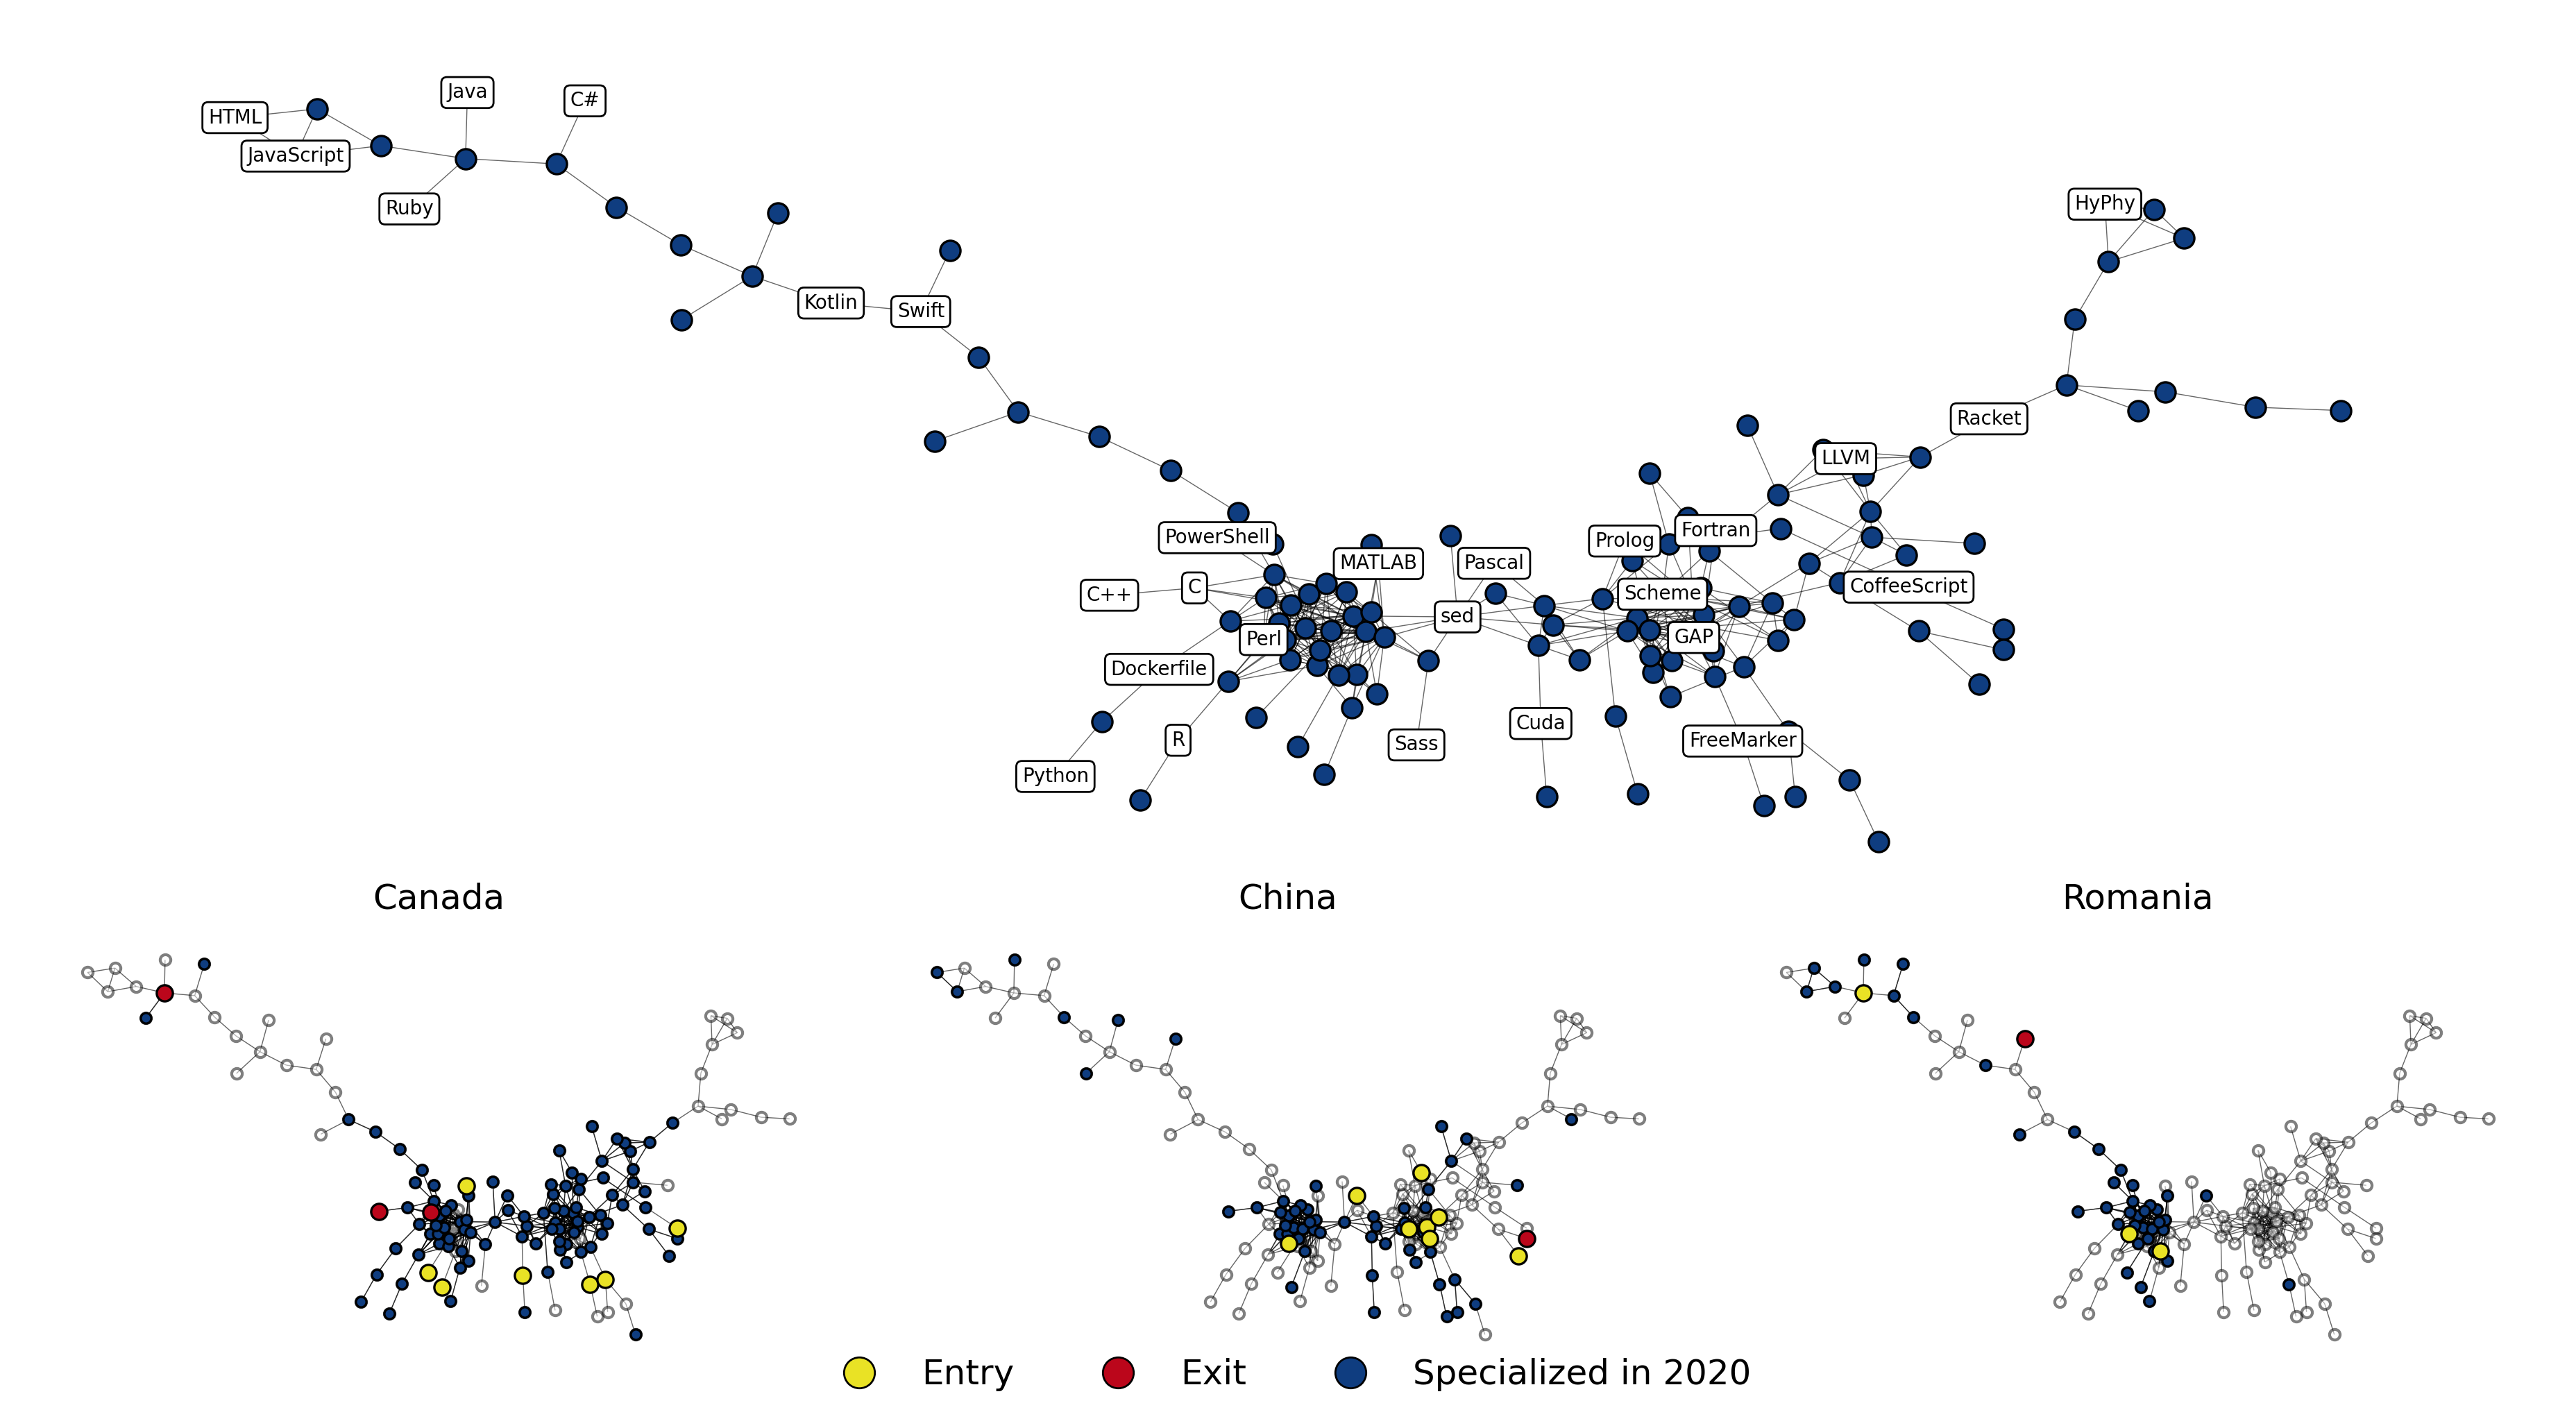

In [8]:
fontsize = 18
rca_color = "#0F3D80"
entry_color = "#E9E225"
exit_color = "#BB061B"
# node_color = "#B4C0D2"
c1= "CA"
c2= "CN"
c3= "RO"

el1 = software_space_of_country(el, cdf, country_code=c1)
graph1 = nx.from_pandas_edgelist(el1, source="language_1", target="language_2")
el2 = software_space_of_country(el, cdf, country_code=c2)
graph2 = nx.from_pandas_edgelist(el2, source="language_1", target="language_2")
el3 = software_space_of_country(el, cdf, country_code=c3)
graph3 = nx.from_pandas_edgelist(el3, source="language_1", target="language_2")


c1_spec= list(cdf[(cdf['rca']>1)&(cdf['year']==2020)&(cdf["iso2_code"] == c1)]["language"])
c1_entry = list(entry[(entry["iso2_code"] == c1) & (entry["entry01"] >= 1)]["language"])
c1_exit = list(exit[(exit["iso2_code"] == c1) & (exit["exit01"] >= 1)]["language"])

c2_spec= list(cdf[(cdf['rca']>1)&(cdf['year']==2020)&(cdf["iso2_code"] == c2)]["language"])
c2_entry = list(entry[(entry["iso2_code"] == c2) & (entry["entry01"] >= 1)]["language"])
c2_exit = list(exit[(exit["iso2_code"] == c2) & (exit["exit01"] >= 1)]["language"])

c3_spec= list(cdf[(cdf['rca']>1)&(cdf['year']==2020)&(cdf["iso2_code"] == c3)]["language"])
c3_entry = list(entry[(entry["iso2_code"] == c3) & (entry["entry01"] >= 1)]["language"])
c3_exit = list(exit[(exit["iso2_code"] == c3) & (exit["exit01"] >= 1)]["language"])


fig = plt.figure(figsize=(18,10))
ax = [0]*8
gs = GridSpec(2, 3, figure=fig, height_ratios=[2.0, 1])
ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[1,0])
ax[2] = fig.add_subplot(gs[1,1])
ax[3] = fig.add_subplot(gs[1,2])


# A -- full graph
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color="black", width=.5, alpha=.6, ax=ax[0])
nx.draw_networkx_nodes(ss_graph, pos, node_size=110, node_color=rca_color, linewidths=1.2, edgecolors='black',
                       ax=ax[0])
nx.draw_networkx_labels(ss_graph.subgraph(posh_list), bbox = dict(facecolor = "white", 
                                    boxstyle="round"), pos=pos, font_size=fontsize-8, ax=ax[0])
ax[0].axis('off')

# B -- subgraph1
nx.draw_networkx_nodes(ss_graph, pos, node_size=30, node_color='white', linewidths=1.5, alpha=.5,
                       edgecolors='black', ax=ax[1])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_edges(graph1, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_nodes(ss_graph.subgraph(c1_spec), pos, node_size=30,alpha=1, node_color=rca_color,linewidths=1.2, edgecolors='black', ax=ax[1])
nx.draw_networkx_nodes(ss_graph.subgraph(c1_entry), pos, node_size=70, node_color=entry_color, linewidths=1.2, edgecolors='black', ax=ax[1])
nx.draw_networkx_nodes(ss_graph.subgraph(c1_exit), pos, node_size=70, node_color=exit_color,linewidths=1.2, edgecolors='black', ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Canada', size=fontsize)


# C -- subgraph2
nx.draw_networkx_nodes(ss_graph, pos, node_size=30, node_color='white', linewidths=1.5, alpha=.5, 
                       edgecolors='black', ax=ax[2])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_edges(graph2, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_nodes(ss_graph.subgraph(c2_spec), pos, node_size=30,alpha=1, node_color=rca_color,linewidths=1.2, edgecolors='black', ax=ax[2])
nx.draw_networkx_nodes(ss_graph.subgraph(c2_entry), pos, node_size=70, node_color=entry_color,linewidths=1.2, edgecolors='black', ax=ax[2])
nx.draw_networkx_nodes(ss_graph.subgraph(c2_exit), pos, node_size=70, node_color=exit_color,linewidths=1.2, edgecolors='black', ax=ax[2])

ax[2].axis('off')
ax[2].set_title('China', size=fontsize)

# C -- subgraph4
nx.draw_networkx_nodes(ss_graph, pos, node_size=30, node_color='white', linewidths=1.5, alpha=.5,
                       edgecolors='black', ax=ax[3])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_edges(graph3, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_nodes(ss_graph.subgraph(c3_spec), pos, node_size=30,alpha=1, node_color=rca_color,linewidths=1.2, edgecolors='black', ax=ax[3])
nx.draw_networkx_nodes(ss_graph.subgraph(c3_entry), pos, node_size=70, node_color=entry_color,linewidths=1.2, edgecolors='black', ax=ax[3])
nx.draw_networkx_nodes(ss_graph.subgraph(c3_exit), pos, node_size=70, node_color=exit_color,linewidths=1.2, edgecolors='black', ax=ax[3])

ax[3].axis('off')
ax[3].set_title('Romania', size=fontsize)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Entry', markerfacecolor=entry_color, markersize=16, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Exit', markerfacecolor=exit_color, markersize=16, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Specialized in 2020', markerfacecolor=rca_color, markersize=16, markeredgecolor='black')

]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.025), ncol=3, fontsize=fontsize, frameon=False)
plt.subplots_adjust(left=-.01, right=1.01, top=0.99, bottom=0.01, wspace=0.00, hspace=0.00)


#ax[0].annotate("A", xy=(0,1), xycoords='axes fraction', xytext=(-40,-50), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[1].annotate("B", xy=(0,1), xycoords='axes fraction', xytext=(-40, 50), textcoords='offset pixels', weight='bold', size=fontsize+5)
#plt.savefig("../figures/figure2_mst_plus_version.png", bbox_inches='tight', dpi=300, facecolor="white")

#ax[0].annotate("A", xy=(0,1), xycoords='axes fraction', xytext=(-10, -30), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[1].annotate("B", xy=(0,1), xycoords='axes fraction', xytext=(-10, 20), textcoords='offset pixels', weight='bold', size=fontsize+5)
#plt.savefig("../figures/figure2_mst_plus_version.pdf", bbox_inches='tight', dpi=300, facecolor="white")

**Figure 3 -- GPT impact**

In [68]:
# ECI_software data
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
#cdf = cdf[cdf["year"]==focal_year]
cdf = cdf[cdf["year"]==2021]

# GPT impact data
gpt = pd.read_csv('../data/gpt_effect_estimates.csv',index_col=0)

In [69]:
language_complexity = dict(cdf.groupby(['language'])['pci'].first())

In [70]:
map_names = {
    'vbscript':'VBScript',
    'objective-c':'Objective-C',
    'actionscript':'ActionScript',
    'gdb':'GDB',
    'tsql':'TSQL',
    'matlab':'MATLAB',
    'vb.net':'Visual Basic .NET',
    'php':'PHP',
    'coffeescript':'CoffeeScript',
    'asp.net':'ASP.NET',
    'qml':'QML',
    'vba':'VBA',
    'xslt':'XSLT',
    'applescript':'AppleScript',
    'cmake':'CMake',
    'vue.js':'Vue',
    'html':'HTML',
    'css':'CSS',
    'javascript':'JavaScript',
    'jupyter-notebook':'Jupyter Notebook',
    'powershell':'PowerShell',
    'typescript':'TypeScript'  
}

In [71]:
# clean names
clean = {}
for x in gpt.index:
    if x.capitalize() in language_complexity:
        clean[x] = x.capitalize()
    elif x in map_names:
        clean[x] = map_names[x]
    else:
        print(x)

gpt.index = gpt.index.map(lambda x: clean.get(x,'missing'))
gpt_effect = dict(gpt[gpt.index != 'missing'].estimate)

delphi
coldfusion
arduino
hive
click
cucumber
max
gradle
sas
sed
io
nginx
sql
plsql


In [72]:
# join and prepare for the plot
cdf2 = cdf[["language", "ubiquity"]].drop_duplicates().reset_index()
cdf2['gpt_effect'] = cdf2['language'].map(gpt_effect)
cdf2 = cdf2[~cdf2['gpt_effect'].isnull()]
cdf2['ubiquity'] = cdf2['ubiquity'].map(np.log)
cdf2['gpt_effect'] = 1 - cdf2['gpt_effect']

R^2: -16.10
p:0.00038627144689053726
0.46981368921644046


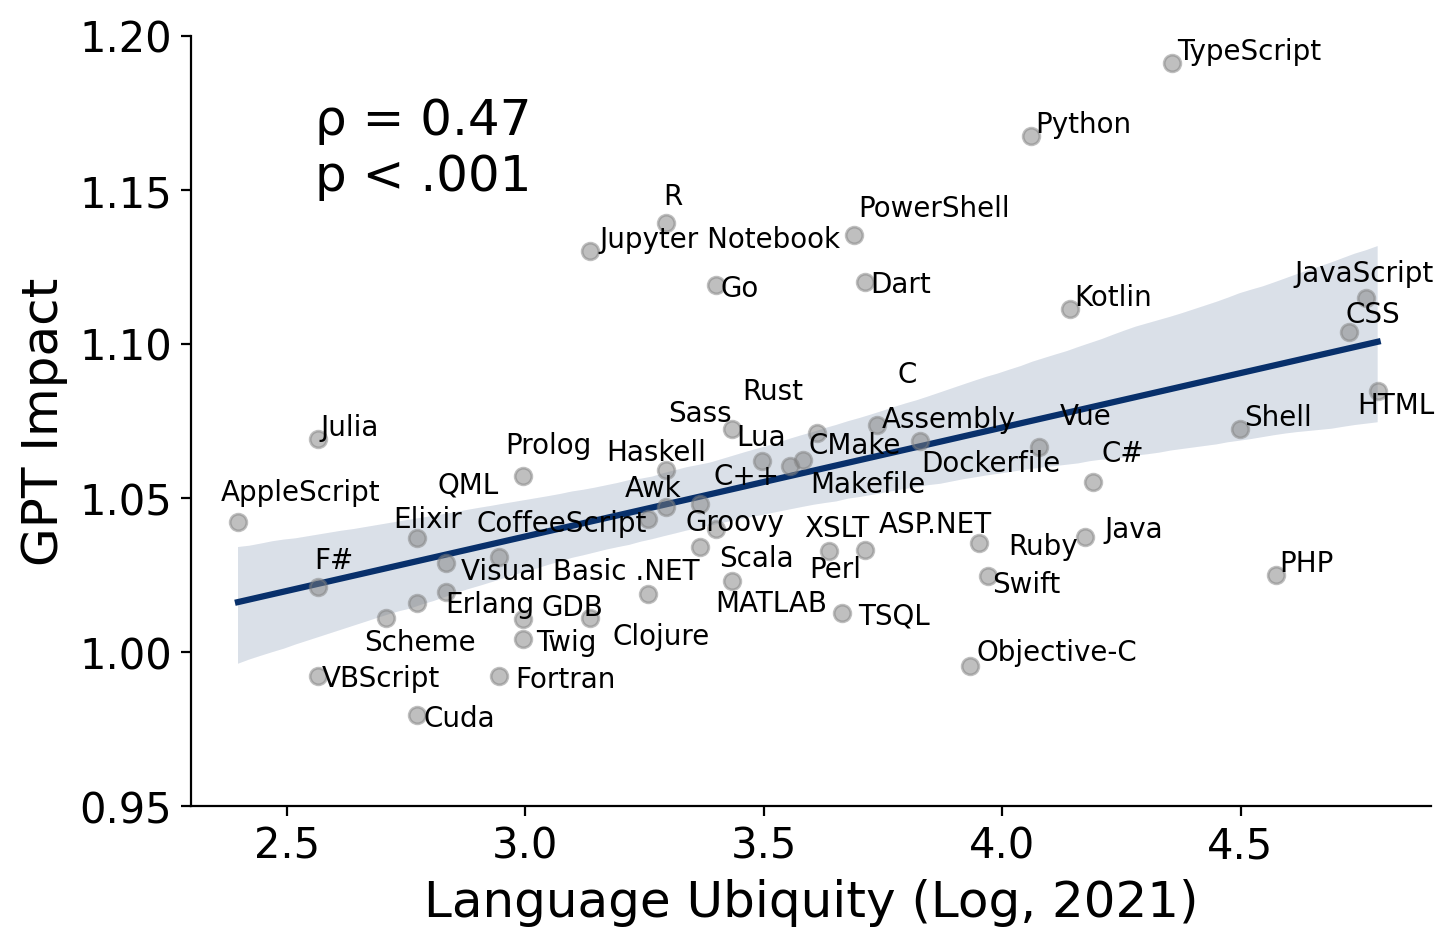

In [80]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
fontsize = 18

# plot the scatter plot with error bars
ax.errorbar(
    cdf2['ubiquity'],
    cdf2['gpt_effect'],
    yerr=0,
    fmt='o',
    capsize=0,
    label='Observations',
    color='#808080',
    alpha=.5
)

# fit a line to the data
model = LinearRegression()
model.fit(cdf2[['ubiquity']], cdf2['gpt_effect'])

# get the line's y values
cdf2['y_fit'] = model.predict(cdf2[['ubiquity']])

# plot the line
sns.regplot(x='ubiquity', y='gpt_effect', data=cdf2, ci=95, line_kws={'color': '#08306b', 'label':'Fit'}, scatter=False, ax=ax)

# labels
texts= []
for i, row in cdf2.iterrows():
    texts.append(ax.annotate(row['language'], (row['ubiquity'], row['gpt_effect']), size=fontsize-8))
adjust_text(texts)

# report R2
r2 = r2_score(cdf2['ubiquity'], cdf2['gpt_effect'])
print(f'R^2: {r2:.2f}')

pearson_corr, p_value = stats.pearsonr(cdf2['ubiquity'], cdf2['gpt_effect'])
print('p:'+str(p_value))
print(pearson_corr)
ax.annotate(f'ρ = {pearson_corr:.2f}\np < .001',
             xy=(0.1, 0.8), xycoords='axes fraction', size=fontsize,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=.5'))

ax.set_xlabel('Language Ubiquity (Log, 2021)', size=fontsize)
ax.set_ylabel('GPT Impact', size=fontsize)
ax.tick_params("x", labelsize=(fontsize-3))
ax.tick_params("y", labelsize=(fontsize-3))
ax.margins(0.0125, tight=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(2.3, 4.9)
ax.set_ylim(0.95, 1.2)

plt.savefig("../figures/figure3_gpt_impact.png", bbox_inches='tight', dpi=300, facecolor="white")